# Extract barrier island metrics along transects
Extract barrier island metrics along transects for Bayesian Network Deep Dive

Author: Emily Sturdivant, esturdivant@usgs.gov

Back-up contact: Ben Gutierrez, bgutierrez@usgs.gov

Pre-requisites:
- All the input layers (transects, shoreline, etc.) must be ready. This is performed with prepper.ipynb.
- The files servars.py and configmap.py may need to be updated for the current dataset.

Notes:
- Run in ArcGIS Pro python 3 environment (access as: \ArcGIS\Pro\bin\Python\Scripts\proenv);
- Spatial reference used is NAD 83 UTM 19N: arcpy.SpatialReference(26918)
    
### Import modules

In [1]:
import os
import sys
import time
import shutil
import pandas as pd
import numpy as np
import arcpy
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import CoastalVarExtractor.functions_warcpy as fwa
import CoastalVarExtractor.functions as fun

If you refuse to install:

```python
mod_path = "C:\Users\esturdivant\Code\BI-geomorph-extraction" # replace with path to module
sys.path.append(mod_path)
import CoastalVarExtractor.functions_warcpy as fwa
import CoastalVarExtractor.functions as fun
```

### Initialize variables

Based on the project directory, and the site and year you have input, setvars.py will set a bunch of variables as the names of folders, files, and fields. Set-up the project folder and paths: 

In [2]:
from CoastalVarExtractor.setvars import *

site: Fisherman
year: 2014
setvars.py initialized variables.


## Transect-averaged values
We work with the shapefile/feature class as a Pandas Dataframe as much as possible to speed processing and minimize reliance on the ArcGIS GUI display.

1. Create a pandas dataframe from the transects feature class. In the process, we remove some of the unnecessary fields. The resulting dataframe is indexed by sort_ID with columns corresponding to the attribute fields in the transects feature class. 

In [43]:
# Copy feature class to dataframe.
trans_df = fwa.FCtoDF(extendedTrans, id_fld=tID_fld, extra_fields=extra_fields)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

Converting feature class to array...
Converting array to dataframe...


In [44]:
# Display
print("\nHeader of transects dataframe (rows 1-5 out of {}): ".format(len(trans_df)))
trans_df.head()


Header of transects dataframe (rows 1-5 out of 194: 


,Azimuth,LCI90,LR2,LRR,LSE,TransOrder,TransectId,sort_ID
sort_ID,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


### Add XY and Z/slope from DH, DL, SL points within 25 m of transects
Add to the dataframe the positions of the nearest pre-created beach geomorphic features. For each type of feature (shoreline, dune toe, and dune crest) 

#### Shoreline

The MHW shoreline easting and northing (SL_x, SL_y) are the coordinates of the intersection of the oceanside shoreline with the transect. Each transect is assigned the foreshore slope (Bslope) from the nearest shoreline point within 25 m. These values are populated for each transect as follows: 
1. get SL_x and SL_y at the point where the transect crosses the oceanside shoreline; 
2. find the closest shoreline point to the intersection point; 
3. copy the slope value from the shoreline point to the transect in the field Bslope.

In [ ]:
# Get the XY position where transect crosses the oceanside shoreline
sl2trans_df = fwa.add_shorelinePts2Trans(extendedTrans, ShorelinePts, shoreline, 
                                         tID_fld, proximity=pt2trans_disttolerance)

# Save as pickle
sl2trans_df.to_pickle(os.path.join(scratch_dir, 'sl2trans.pkl'))

# Convert dataframe to feature class
fwa.DFtoFC(sl2trans_df, os.path.join(arcpy.env.scratchGDB, 'pts2trans_SL'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["SL_x", "SL_y"], keep_fields=['Bslope'])

#### Dune positions along transects

DL_x, DL_y, and DL_zMHW are the easting, northing, and height above MHW, respectively, of the nearest dune toe point within 25 meters of the transect. DH_x, DH_y, and DH_zMHW are the easting, northing, and height above MHW, respectively, of the nearest dune crest point within 25 meters. 

Get the XYZ positions of the nearest dune crest and dune toe within 25 meters of each transect with the following process for each transect: 

1. Find the nearest dune crest/toe point to the transect and proceed if the distance is less than 25 m. 
2. Get the Z value from the point and the XY position 'snapped' to the transect. The 'snapped' XY position is calculated using the arcpy geometry method, which produces a position along the transect nearest to the identified point, i.e. orthogonal to the point. If there are no points within 25 m of the transect, populate the row with a Null value; 
3. Convert the elevations to the MHW datum by applying the MHW offset.

In [5]:
# Dune crest - Create dataframe, Save, Convert to a feature class
dh2trans_df = fwa.find_ClosestPt2Trans_snap(extendedTrans, dhPts, trans_df, 'DH', 
                                            tID_fld, proximity=pt2trans_disttolerance)
dh2trans_df.to_pickle(os.path.join(scratch_dir, 'dh2trans.pkl'))
fwa.DFtoFC(dh2trans_df, os.path.join(arcpy.env.scratchGDB, 'ptSnap2trans_DH'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["DH_snapX", "DH_snapY"], keep_fields=['DH_z'])

# Dune toe - Create dataframe, Save, Convert to a feature class
dl2trans_df = fwa.find_ClosestPt2Trans_snap(extendedTrans, dlPts, trans_df, 'DL', 
                                            tID_fld, proximity=pt2trans_disttolerance)
dl2trans_df.to_pickle(os.path.join(scratch_dir, 'dl2trans.pkl'))
fwa.DFtoFC(dl2trans_df, os.path.join(arcpy.env.scratchGDB, 'ptSnap2trans_DL'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["DL_snapX", "DL_snapY"], keep_fields=['DL_z'])


Joining shoreline points to transects...
...duration at transect 100: 0:0:21.8 seconds
Duration: 0:0:41.5 seconds

Joining DH points to transects:
Getting name of Z field...
Looking for field _z
Looping through transects to find nearest point within 25 meters...
Duration at transect 100: 0:0:14.5 seconds
Duration: 0:0:26.4 seconds

Joining DL points to transects:
Getting name of Z field...
Looking for field _z
Looping through transects to find nearest point within 25 meters...
Duration at transect 100: 0:0:13.4 seconds
Duration: 0:0:24.3 seconds

Armoring file either missing or empty so we will proceed without armoring data. If shorefront tampering is present at this site, cancel the operations to digitize.


,Azimuth,LCI90,LR2,LRR,LSE,TransOrder,TransectId,SL_x,SL_y,Bslope,...,DH_snapX,DH_snapY,DL_x,DL_y,DL_z,DL_snapX,DL_snapY,Arm_x,Arm_y,Arm_z
sort_ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413851.177269,4.107531e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413809.698456,4.107514e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413778.475432,4.107478e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413746.021688,4.107456e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413702.743869,4.107442e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Armoring
Arm_x, Arm_y, and Arm_zMHW are the easting, northing, and height above MHW, respectively, where an artificial structure crosses the transect in the vicinity of the beach. These features are meant to supplement the dune toe data set by providing an upper limit to the beach in areas where dune toe extraction was confounded by the presence of an artificial structure. Values are populated for each transect as follows: 

1. Get the positions of intersection between the digitized armoring lines and the transects (Intersect tool from the Overlay toolset); 
2. Extract the elevation value at each intersection point from the DEM (Extract Multi Values to Points tool from Spatial Analyst); 
4. Convert the elevations to the MHW datum by applying the MHW offset.

In [ ]:
# Armoring line
arm2trans_df = fwa.ArmorLineToTrans_PD(extendedTrans, armorLines, sl2trans_df, tID_fld, proj_code, elevGrid_5m)

# Save
arm2trans_df.to_pickle(os.path.join(scratch_dir, 'arm2trans.pkl'))

### Add all the positions to the trans_df
Join the new dataframes to the transect dataframe. Before it performs the join, `join_columns_id_check()` checks the index and the ID field for potential errors such as whether they are the equal and whether there are duplicated IDs or null values in either.

In [ ]:
# Join positions of shoreline, dune crest, dune toe, armoring
trans_df = fun.join_columns_id_check(trans_df, sl2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, dh2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, dl2trans_df, tID_fld)
trans_df = fun.join_columns_id_check(trans_df, arm2trans_df, tID_fld)

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))
# trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))

# Display
trans_df.head()

In [3]:
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics.pkl'))

### Calculate upper beach width and height
Upper beach width (uBW) and upper beach height (uBH) are calculated based on the difference in position between two points: the position of MHW along the transect (SL_x, SL_y) and the dune toe position or equivalent (usually DL_x, DL_y).  In some cases, the dune toe is not appropriate to designate the "top of beach" so beach width and height are calculated from either the position of the dune toe, the dune crest, or the base of an armoring structure. The dune crest was only considered a possibility if the dune crest elevation (DH_zMHW) was less than or equal to `maxDH`. 

They are calculated as follows: 
1. Find the position along the transect of an orthogonal line drawn to the dune point (DL_x, DL_y and DH_x, DH_y)
2. Calculate distances from MHW to the position along the transect of the dune toe (DistDL), dune crest (DistDH), and armoring (DistArm). 
3. Conditionally select the appropriate feature to represent "top of beach." Dune toe is prioritized. If it is not available and DH_zMHW is less than or equal to maxDH, use dune crest. If neither of the dune positions satisfy the conditions and an armoring feature intersects with the transect, use the armoring position. If none of the three are possible, uBW and uBH will be null. 
4. Copy the distance to shoreline and height above MHW (Dist--, ---zMHW) to uBW and uBH, respectively. 

In [4]:
#%% Calculate distances from shore to dunes, etc.
trans_df, dl2trans, dh2trans, arm2trans = fwa.calc_BeachWidth_fill(extendedTrans, trans_df, maxDH, tID_fld, MHW, fill)

#### Spot-check the beach width values.

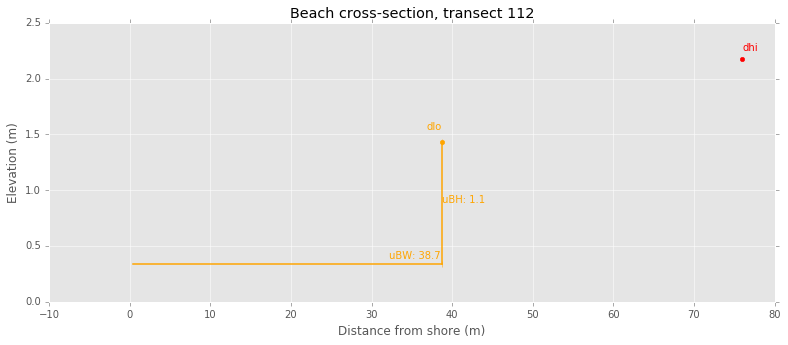

In [71]:
# View distribution of uBW values as descriptive stats and histogram.
fld = 'uBW'
print(pts_df[fld].describe())
pts_df[fld].hist()
plt.show()
plt.close('all')

# Randomly sample 5 rows
ran_samp = trans_df.sample(5)
ran_samp.loc[:,['SL_x', 'SL_y', 'DistDL', 'DL_zmhw', 'DistDH', 'DH_zmhw', 'DistArm', 'Arm_zmhw', 'uBW', 'uBH']]

# For one row, plot the dlo, dhi position with uBW and uBH
tran = ran_samp.iloc[0]

# Beach detail
fig = plt.figure(figsize=(13,5)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(111)

# Subplot Labels
ax.set_xlabel('Distance from shore (m)', fontsize = 12)
ax.set_ylabel('Elevation (m)', fontsize = 12)
ax.set_title('Beach cross-section, transect {}'.format(tran.name))

# Beach points
plt.scatter(tran.DistDL, tran.DL_z, color='orange')
plt.annotate('dlo', xy=(tran.DistDL-tran.DistDL*0.05, tran.DL_z+tran.DL_z*0.08), color='orange')
plt.scatter(tran.DistDH, tran.DH_z, color='red')
plt.annotate('dhi', xy=(tran.DistDH-0.02, tran.DH_z+0.08), color='red')
plt.scatter(tran.DistArm, tran.Arm_z, color='black')
plt.annotate('armor', xy=(tran.DistArm-20, tran.Arm_z+0.5), color='black')

# Upper beach width and height
uBW = tran.uBW
uBH = tran.uBH
plt.plot([MHW, uBW],[MHW, MHW], color='orange', linestyle='-', linewidth = 1.5)
plt.annotate('uBW: {:.1f}'.format(uBW), xy=(uBW*0.83, MHW+0.05), color='orange')
plt.plot([uBW, uBW],[MHW, MHW + uBH], color='orange', linestyle='-', linewidth = 1.5, marker='|')
plt.annotate('uBH: {:.1f}'.format(uBH), xy=(uBW+0.03, MHW+uBH*0.5), color='orange')

plt.show()
plt.close('all')

### Dist2Inlet

In [5]:
# Dist2Inlet: Calc dist from inlets 
dist_df = fwa.measure_Dist2Inlet(shoreline, extendedTrans, inletLines, tID_fld)
dist_df.to_pickle(os.path.join(scratch_dir, 'dist2inlet_df.pkl'))
trans_df = fun.join_columns_id_check(trans_df, dist_df, tID_fld, fill=fill)

Duration: 0:0:2.2 seconds


In [7]:
# QC: difference in dist2inlet between consecutive transects.
# dist_df = pd.read_pickle(os.path.join(scratch_dir, 'dist2inlet_df.pkl'))
# # trans_df.loc[14:17, 'Dist2Inlet']
# dist_df = dist_df.join(dist_df.diff(), rsuffix='_diff')
df_diff = trans_df['Dist2Inlet'].diff()
df_diff
trans_df.loc[df_diff['DistDL'] > 144, ['DistDL']]

sort_ID
1             NaN
2       46.581440
3       49.465238
4       40.156766
5       46.552161
6       44.417146
7       45.963928
8       51.051740
9       47.714087
10      47.534047
11      45.791502
12            NaN
13            NaN
14            NaN
15     210.740015
16      89.757390
17      76.970940
18      83.416742
19      75.027649
20      65.260996
21      63.013433
22      61.898346
23      57.735353
24      57.761350
25      48.171153
26      46.015902
27      48.257928
28      41.604581
29      49.312415
30      54.984802
          ...    
165    -64.186760
166    -75.271409
167    -70.252216
168    -76.322080
169    -79.355948
170    -69.211621
171    -46.314709
172    -51.083251
173    -49.753700
174    -52.069120
175    -52.490574
176    -52.022747
177    -54.724334
178    -51.787662
179    -51.220722
180    -48.735647
181    -51.828115
182    -52.671787
183    -53.869904
184    -51.013311
185    -51.253029
186    -68.022947
187           NaN
188           NaN
18

### Clip transects, get barrier widths *SPATIAL*

In [12]:
# Clip transects, get barrier widths *SPATIAL*
widths_df = fwa.calc_IslandWidths(extendedTrans, barrierBoundary, tID_fld=tID_fld)
trans_df = fun.join_columns_id_check(trans_df, widths_df, tID_fld, fill=fill)
trans_df.to_pickle(os.path.join(scratch_dir, extTrans_null+'_prePts.pkl'))
# trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'_prePts.pkl'))

Clipping the transects to the barrier island boundaries...
Getting the width along each transect of the oceanside land (WidthPart)...
Converting feature class to array...
Converting array to dataframe...
Getting the width along each transect of the entire barrier (WidthFull)...
Converting feature class vertices to array with X and Y...
Converting array to dataframe...
Getting the width along each transect of above water portion of the barrier (WidthLand)...


## 5m Points

In [14]:
# trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'_prePts.pkl'))
transPts_presort


'\\\\Mac\\stor\\Projects\\TransectExtraction\\Fisherman2014\\scratch.gdb\\tran5mPts_unsorted'

In [13]:
# if os.path.exists(os.path.join(scratch_dir, transPts_null+'.pkl')):
#     pts_df = pd.read_pickle(os.path.join(scratch_dir,transPts_null+'.pkl'))
#     trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'_prePts.pkl'))
pts_df, transPts_presort = fwa.TransectsToPointsDF(extTrans_tidy, barrierBoundary, fc_out=transPts_presort) # 4 minutes for FireIsland

Getting points every 5m along each transect and saving in dataframe...
Converting new dataframe to feature class...
Duration: 0:1:25.1 seconds


In [15]:
# if not 'ptZ' in pts_df.columns:
    # Extract elevation and slope at points
if not arcpy.Exists(elevGrid_5m):
    fwa.ProcessDEM(elevGrid, elevGrid_5m, utmSR)
if not arcpy.Exists(slopeGrid):
    arcpy.Slope_3d(elevGrid_5m, slopeGrid, 'PERCENT_RISE')
arcpy.sa.ExtractMultiValuesToPoints(transPts_presort, 
                                    [[elevGrid_5m, 'ptZ'], [slopeGrid, 'ptSlp']]) # 9 min for ParkerRiver

<geoprocessing server result object at 0xba33e90>

In [16]:
pts_df = fwa.FCtoDF(transPts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp'])
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_df_elev_slope.pkl'))

pts_df.head()

Converting feature class to array with X and Y...
Converting array to dataframe...


,SHAPE@X,SHAPE@Y,ptSlp,ptZ,sort_ID
0,413851.177269,4.107531e+06,5.669233,-0.162717,1.0
1,413853.654371,4.107527e+06,5.935968,-0.043215,1.0
2,413856.131473,4.107523e+06,22.361212,0.712121,1.0
3,413858.608576,4.107518e+06,21.225933,1.064813,1.0
4,413861.085678,4.107514e+06,26.451097,2.700293,1.0


In [17]:
pts_df = pd.read_pickle(os.path.join(scratch_dir, 'pts_df_elev_slope.pkl'))
pts_df.head()

,SHAPE@X,SHAPE@Y,ptSlp,ptZ,sort_ID
0,413851.177269,4.107531e+06,5.669233,-0.162717,1.0
1,413853.654371,4.107527e+06,5.935968,-0.043215,1.0
2,413856.131473,4.107523e+06,22.361212,0.712121,1.0
3,413858.608576,4.107518e+06,21.225933,1.064813,1.0
4,413861.085678,4.107514e+06,26.451097,2.700293,1.0


### Calculate DistSeg, Dist_MHWbay, DistSegDH, DistSegDL, DistSegArm, sort points

In [18]:
#%%
# Calculate DistSeg, Dist_MHWbay, DistSegDH, DistSegDL, DistSegArm, sort points
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)
pts_df = fun.prep_points(pts_df, tID_fld, pID_fld, MHW, fill)
# Aggregate ptZmhw to max and mean and join to transPts and extendedTransects
pts_df, zmhw = fun.aggregate_z(pts_df, MHW, tID_fld, 'ptZ', fill)
trans_df = fun.join_columns(trans_df, zmhw) # join new fields to transects
pts_df = fun.join_columns(pts_df, trans_df, tID_fld) # Join transect values to pts

# Housecleaning
trans_df.drop(extra_fields, axis=1, inplace=True, errors='ignore') # Drop extra fields
pts_df.drop(extra_fields, axis=1, inplace=True, errors='ignore') # Drop extra fields

#%% Save dataframes to open elsewhere or later
trans_df.to_pickle(os.path.join(scratch_dir, extTrans_null+'.pkl'))
pts_df.to_pickle(os.path.join(scratch_dir, transPts_null+'.pkl'))

In [19]:
pts_df = pd.read_pickle(os.path.join(scratch_dir, transPts_null+'.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, extTrans_null+'.pkl'))
pts_df.head()

,SplitSort,seg_x,seg_y,ptSlp,ptZ,sort_ID,Dist_Seg,DistSegArm,DistSegDH,DistSegDL,...,DistArm,uBW,uBH,ub_feat,Dist2Inlet,WidthFull,WidthLand,WidthPart,mean_Zmhw,max_Zmhw
0,0,413851.177269,4.107531e+06,5.669233,-0.162717,1,5.963374e-09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,79.016858,126.319423,126.319423,126.319423,2.523506,3.498424
1,1,413853.654371,4.107527e+06,5.935968,-0.043215,1,5.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,79.016858,126.319423,126.319423,126.319423,2.523506,3.498424
2,2,413856.131473,4.107523e+06,22.361212,0.712121,1,1.000000e+01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,79.016858,126.319423,126.319423,126.319423,2.523506,3.498424
3,3,413858.608576,4.107518e+06,21.225933,1.064813,1,1.500000e+01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,79.016858,126.319423,126.319423,126.319423,2.523506,3.498424
4,4,413861.085678,4.107514e+06,26.451097,2.700293,1,2.000000e+01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,79.016858,126.319423,126.319423,126.319423,2.523506,3.498424


## Quality checking


In [20]:
# 140 is a good one.
trans_in = int(input('Transect ID ({:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]
# plot
fig = plt.figure(figsize=(13,10)) # Set the size of your figure, customize for more subplots
ax = fig.add_subplot(211)
fun.plot_island_profile(ax, pts_set, MHW, MTL)
ax = fig.add_subplot(212)
fun.plot_beach_profile(ax, pts_set, MHW, MTL)
# display
plt.show()
plt.close('all')

Transect ID (1-194): 50


ValueError: posx and posy should be finite values

count    34416.000000
mean       569.171680
std        407.110356
min          0.000000
25%        235.000000
50%        500.000000
75%        820.000000
max       1831.092811
Name: Dist_Seg, dtype: float64


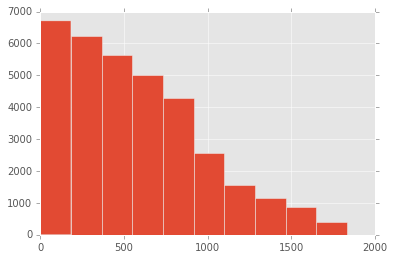

In [32]:
fld = 'Dist_Seg'
print(pts_df[fld].describe())
pts_df[fld].hist()
plt.show()

## Outputs

In [21]:
#%% Join calculated transect values to the transect FC.
trans_fc = fwa.JoinDFtoFC(trans_df, extendedTrans, tID_fld, out_fc=extTrans_fill)
# DeleteExtraFields(trans_fc, trans_flds)
fwa.CopyFCandReplaceValues(trans_fc, fill, None, out_fc=extTrans_null, out_dir=home)
# Save final SHP with fill values
arcpy.FeatureClassToFeatureClass_conversion(trans_fc, scratch_dir, extTrans_shp+'.shp')

OUTPUT: Fisherman2014_extTrans_null


<Result '\\\\Mac\\stor\\Projects\\TransectExtraction\\Fisherman2014\\scratch\\Fisherman2014_extTrans_shp.shp'>

### Save final pts with fill values as CSV

In [22]:
#%% Save final pts with fill values as CSV
if not pID_fld in pts_df.columns:
    pts_df.reset_index(drop=False, inplace=True)
csv_fname = os.path.join(scratch_dir, transPts_fill +'.csv')
pts_df.to_csv(os.path.join(scratch_dir, transPts_fill +'.csv'), na_rep=fill, index=False)
print("OUTPUT: {}".format(csv_fname))

OUTPUT: \\Mac\stor\Projects\TransectExtraction\Fisherman2014\scratch\Fisherman2014_transPts_fill.csv


### Create Beach Width raster by joining DF to ID raster

In [26]:
#%% Create Beach Width raster by joining DF to ID raster
if not arcpy.Exists(rst_transIDpath):
    outEucAll = arcpy.sa.EucAllocation(extTrans_tidy, maximum_distance=50, cell_size=cell_size, source_field=tID_fld)
    outEucAll.save(os.path.basename(rst_transIDpath))
out_rst = fwa.JoinDFtoRaster(trans_df, rst_transID, bw_rst, fill, tID_fld, 'uBW')

OUTPUT: fish14_ubw. Field "Value" is ID and "uBW" is beachwidth.


### Convert pts_df to FC, both pts and trans (pts_fc, trans_fc)

In [23]:
#%% Convert pts_df to FC, both pts and trans (pts_fc, trans_fc)
pts_fc = fwa.DFtoFC_large(pts_df, out_fc=os.path.join(arcpy.env.workspace, transPts_fill), spatial_ref=utmSR, df_id=pID_fld, xy=["seg_x", "seg_y"])
# DeleteExtraFields(pts_fc, pt_flds+trans_flds)
# Save final FCs with null values, final SHP and XLS with fill values
fwa.CopyFCandReplaceValues(pts_fc, fill, None, out_fc=transPts_null, out_dir=home)
arcpy.FeatureClassToFeatureClass_conversion(pts_fc, scratch_dir, transPts_shp+'.shp')
try:
    xls_fname = os.path.join(scratch_dir, transPts_fill +'.xlsx')
    pts_df.to_excel(xls_fname, na_rep=fill, index=False)
    print("OUTPUT: {}".format(xls_fname))
except:
    print("No Excel file created. You'll have to do it yourself from the CSV.")

Converting points DF to FC...
OUTPUT: \\Mac\stor\Projects\TransectExtraction\Fisherman2014\Fisherman2014.gdb\Fisherman2014_transPts_fill
Duration: 0:2:37.6 seconds
OUTPUT: Fisherman2014_transPts_null
No Excel file created. You'll have to do it yourself from the CSV.


In [34]:
pts_df.to_json(os.path.join(scratch_dir, transPts_null+'.json'))
trans_df.to_json(os.path.join(scratch_dir, extTrans_null+'.json'))

In [35]:
pts_dfj = pd.read_json(os.path.join(scratch_dir, transPts_null+'.json'))
trans_dfj = pd.read_json(os.path.join(scratch_dir, extTrans_null+'.json'))

In [36]:
pts_dfj.equals(pts_df)

False

In [37]:
trans_dfj.equals(trans_df)

False

,Arm_x,Arm_y,Arm_z,Arm_zmhw,Azimuth,Bslope,DH_snapX,DH_snapY,DH_x,DH_y,...,mean_Zmhw,ptSlp,ptZ,ptZmhw,seg_x,seg_y,sort_ID,uBH,uBW,ub_feat
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.523506,5.669233,-0.162717,-0.502717,413851.177269,4.107531e+06,1.0,NaN,NaN,None
SplitSort,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [39]:
pts_df.head()

,SplitSort,seg_x,seg_y,ptSlp,ptZ,sort_ID,Dist_Seg,DistSegArm,DistSegDH,DistSegDL,...,DistArm,uBW,uBH,ub_feat,Dist2Inlet,WidthFull,WidthLand,WidthPart,mean_Zmhw,max_Zmhw
0,0,413851.177269,4.107531e+06,5.669233,-0.162717,1,5.963374e-09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,79.016858,126.319423,126.319423,126.319423,2.523506,3.498424
1,1,413853.654371,4.107527e+06,5.935968,-0.043215,1,5.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,79.016858,126.319423,126.319423,126.319423,2.523506,3.498424
2,2,413856.131473,4.107523e+06,22.361212,0.712121,1,1.000000e+01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,79.016858,126.319423,126.319423,126.319423,2.523506,3.498424
3,3,413858.608576,4.107518e+06,21.225933,1.064813,1,1.500000e+01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,79.016858,126.319423,126.319423,126.319423,2.523506,3.498424
4,4,413861.085678,4.107514e+06,26.451097,2.700293,1,2.000000e+01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,79.016858,126.319423,126.319423,126.319423,2.523506,3.498424


In [ ]:
fld = 'Dist_Seg'
print(pts_df[fld].describe())
pts_df[fld].hist()
plt.show()